In [1]:
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'
import numpy as np

# Figures plotted inside the notebook

# High quality figures

### Integrantes
    - Yajaira Huerta
    - Oscar Dueñas
    - Henry Avila


# Mini Proyecto 2

## Aprendizaje Automático Intermedio e Ingeniería de Características

### Abril 2023

**Emilio Parrado Hernández, Vanessa Gómez Verdejo, Pablo Martínez Olmos**

Departamento de Teoría de la Señal y Comunicaciones

**Universidad Carlos III de Madrid**

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

# Introducción 

En este notebook vamos a trabajar técnicas para resolver con SVM un problema en el que el número de observaciones del conjunto de entrenamiento es razonablemente grande. En estos casos **renunciamos a conseguir la SVM global que obtendríamos entrenando con todas las observaciones** y la tratamos de aproximar con dos estrategias que impliquen resolver SVMs con tamaños de conjunto de entrenamiento que nos podamos permitir.

Concretamente vamos a abordar dos estrategias de aproximación principales:
- **Bagging de SVMs**: Entrenar varias SVMs, cada una de ellas con un subconjunto de los datos de entrenamiento y determinar las predicciones para el conjunto de test mediante la combinación de las predicciones individuales de cada SVM (voto de la mayoría)
- **SVM distribuida**: Explotar el resultado de la dispersión de la solución de la SVM. Dado que los vectores soporte son las **únicas observaciones que realmente necesitamos para construir la SVM**, podemos emplear las SVM entrenadas con los subconjuntos de entrenamiento de tamaño reducido para tratar de  **detectar los vectores soporte de la SVM global que obtendríamos entrenando con todas las observaciones** e intentar aproximar esta SVM entrenando únicamente con esos candidatos a vector soporte de la SVM global.

Los parámetros con los que vamos a evaluar cada una de las aproximaciones son:
- precisión al clasificar el mismo conjunto de test
- estimación del coste computacional de la implementación


# 0. Carga de datos 

En este notebook vamos a trabajar con la base de datos *benchmark* **ijcnn1**. Este conjunto se utilizó durante una competición *challenge* organizado en la conferencia IJCNN (*International Joint Conference on Neural Networks*) de 2001.

El conjunto de datos ya está dividido en entrenamiento y test. El siguiente código carga ambas particiones, partiendo de que los ficheros `ijcnn1.bz2` y `ijcnn1.t.bz2` están ya descargados en el directorio en el que está el notebook.

In [2]:
from sklearn.datasets import load_svmlight_file
import urllib.request  # the lib that handles the url stuff
target_url = "http://www.tsc.uc3m.es/~emipar/BBVA/INTERMEDIO/DATASETS/ijcnn1"
data = urllib.request.urlopen(target_url)
Xtrain,Ytrain = load_svmlight_file(data)
target_url = "http://www.tsc.uc3m.es/~emipar/BBVA/INTERMEDIO/DATASETS/ijcnn1.t"
data = urllib.request.urlopen(target_url)
Xtest,Ytest = load_svmlight_file(data)


In [3]:
from sklearn.datasets import load_svmlight_file

DATA_DIR = './'

# Xtrain,Ytrain = load_svmlight_file(DATA_DIR+'ijcnn1.bz2')
# Xtest, Ytest = load_svmlight_file(DATA_DIR + 'ijcnn1.t.bz2')
Xtrain = Xtrain.todense()
Xtest = Xtest.todense()
for aa,bb in zip([Xtrain, Xtest],['entrenamiento', 'test']):
    print("Cargadas {0:d} observaciones de {2} con {1:d} dimensiones".format(aa.shape[0], aa.shape[1], bb))

print("")
print("Etiquetas de salida")
print(np.unique(Ytrain))

Cargadas 49990 observaciones de entrenamiento con 22 dimensiones
Cargadas 91701 observaciones de test con 22 dimensiones

Etiquetas de salida
[-1.  1.]


## Clasificación trivial (5%)

El primer paso es establecer el clasificador *baseline* contra el que vamos a comparar los resultados de los modelos que vayamos entrenando a lo largo del *notebook*.

Este resultado depende de si las clases están o no desbalanceadas. **Analizad el desbalanceo de clases en los datos de entrenamiento y decidid un clasificador baseline**.

In [4]:
#############
# YOUR CODE #
#############
import pandas as pd
df_Xtrain = pd.DataFrame(Xtrain)
df_Ytrain = pd.DataFrame(Ytrain)

df_Xtest = pd.DataFrame(Xtest)
df_Ytest = pd.DataFrame(Ytest)
#######
# END #
####### 

-1.0    45137
 1.0     4853
dtype: int64

-1.0    0.902921
 1.0    0.097079
dtype: float64

<AxesSubplot:xlabel='0'>

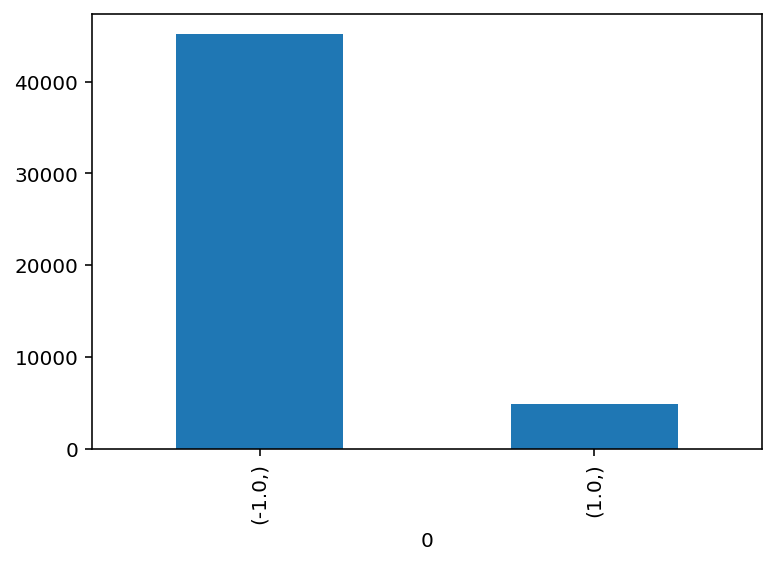

In [5]:
display(df_Ytrain.value_counts())
display(df_Ytrain.value_counts(normalize=True))
df_Ytrain.value_counts().plot.bar()

## Escalado (5%)

La SVM es un clasificador basado en distancias, por lo que suele beneficiarse del escalado de los datos. Para evitar tener que gestionar `pipelines` durante todo el notebook vamos dejar los datos de entrada escalados de una vez con un `StandardScaler`.

Construya los arrays de numpy `Xtrain_s` y `Xtest_s` resultantes de aplicar este escalado a los arrays originales `Xtrain` y `Xtest`. A partir de ahora `Xtrain_s` y `Xtest_s` serán los numpy arrays con las observaciones.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [7]:
#############
# YOUR CODE #
#############
Xtrain = np.asarray(Xtrain)
Xtest = np.asarray(Xtest)
scaler = StandardScaler()
Xtrain_s = scaler.fit_transform(Xtrain)
Xtest_s = scaler.transform(Xtest)
#######
# END #
#######

# 1. Regresión Logística como baseline inmediato alternativo (5%)


La primera tarea consiste en emplear un clasificador más o menos rápido de entrenar para analizar un poco más en detalle las prestaciones que podemos alcanzar.

- Entrenad un modelo de clasificación basado en `LogisticRegression` 

- Comparad la precisión (*score*) del modelo en el conjunto de test con la del clasificador trivial.


In [8]:
#############
# YOUR CODE #
#############
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
logit_model = LogisticRegression()
logit_model.fit(Xtrain_s, Ytrain)
print("Score con data de entrenamiento {0:.4f}".format(logit_model.score(Xtrain_s, Ytrain)))
print("Score con data de test {0:.4f}".format(logit_model.score(Xtest_s, Ytest)))
#######
# END #
#######

Score con data de entrenamiento 0.9248
Score con data de test 0.9202


## 1.3 Pintar pesos y dar interpretación (5%)

Imprimid los pesos del regresor logístico con el nombre de la variable correspondiente

- Peso w0: XXX.XX
- peso Variable1: YYY.YY
- ...
- peso VariableM: ZZZZ.ZZZZ

y comentad la relevancia de cada variable en la clasificación. Puede ser de ayuda imprimir los pesos ordenados por valor absoluto.

In [9]:
#############
# YOUR CODE #
#############
coef = logit_model.coef_.tolist()
df_interpretacion = pd.DataFrame(coef)
print("Cantidad de Coeficientes: " + str(df_interpretacion.shape[1]))
df_interpretacion = df_interpretacion.T
df_interpretacion.columns = ['coef']
df_interpretacion['coef'] = np.abs(df_interpretacion['coef'])
df_interpretacion = df_interpretacion.rename_axis('index',axis=1)
df_interpretacion.sort_values('coef',ascending=False).head(20)
#######
# END #
#######

Cantidad de Coeficientes: 22


index,coef
17,2.454391
16,1.460334
11,1.189675
18,0.967507
21,0.696145
6,0.626593
19,0.596877
20,0.523693
4,0.341726
12,0.301088


<AxesSubplot:xlabel='index'>

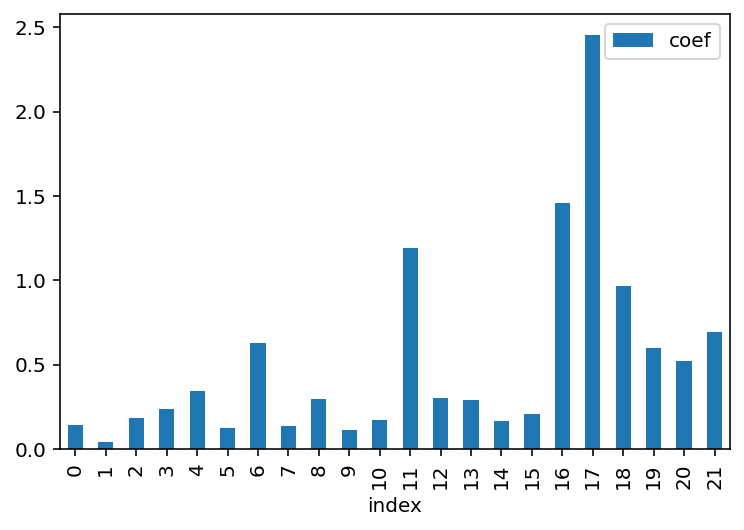

In [10]:
df_interpretacion.reset_index().plot(kind='bar',x='index', y='coef')

# 2. Estudios previos

## 2.1. Estimación de parámetros para la SVM (10%)

La estimación de hiperparámetros es un proceso bastante costoso computacionalmente. Es por ello que para esta sección podéis utilizar una versión simplificada a 5000 observaciones del conjunto de entrenamiento.

Utilice [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) con una validación de 5 conjuntos para determinar:
- el `kernel` para la SVM, eligiendo entre lineal, RBF o polinómico
- el valor del parámetro de regularización $C$ de entre un rango razonable de valores
- el valor del parámetro del kernel correspondiente:
    - `gamma` en el kernel RBF 
    - `degree` en el polinómico
    
En este caso tiene sentido emplear una lista de diccionarios como argumento `param_grid` de `GridSearchCV`; cada elemento de esta lista sería el diccionario correspondiente a cada uno de los kernels que vamos a explorar.



In [11]:
Xtrain_s.shape

(49990, 22)

In [12]:
#############
# YOUR CODE #
#############
from sklearn.model_selection import GridSearchCV
from sklearn import svm


# Se usa train test split con 0.9 de test y 0.1 de entrenamiento para obtener aprox. 5000 muestras
Xtrain_p, Xtest_p, Ytrain_p, Ytest_p = train_test_split(Xtrain_s, Ytrain, test_size=0.899979, random_state=42)

#model = svm.SVC(C=1,kernel='rbf', gamma=0.1)

v_kernel = ['linear','rbf','poly']

v_C = [0.1,1,10,100,1000,10000]
v_gamma = [x / 21 for x in v_C] # "Gamma's iguales a múltiplos de "1 / número features"
v_degree = [2,3,4,5] # grado polinomio

svm_params = [{'kernel':['linear']
              ,'C':v_C
             }
              ,{'kernel':['rbf']
              ,'C':v_C
              ,'gamma' : v_gamma
             },{'kernel':['poly']
              ,'C':v_C
              ,'degree' : v_degree
             }]

grid_svm = GridSearchCV(svm.SVC(), param_grid=svm_params, cv=5, verbose=2, n_jobs=4)
grid_svm.fit(Xtrain_p, Ytrain_p)
print("Score con data de entrenamiento R^2={0:.4f}".format(grid_svm.score(Xtrain_p, Ytrain_p)))
#print("Score with the test data R^2={0:.4f}".format(grid_svm.score(Xtest_s, Ytest)))
print("Hyperparameters escogidos con cross-validation")
print(grid_svm.best_params_)

#######
# END #
#######

Fitting 5 folds for each of 66 candidates, totalling 330 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 20.7min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 23.0min
[Parallel(n_jobs=4)]: Done 330 out of 330 | elapsed: 33.9min finished


Score con data de entrenamiento R^2=0.9904
Hyperparameters escogidos con cross-validation
{'C': 10, 'gamma': 0.047619047619047616, 'kernel': 'rbf'}


**RESPUESTA**

**Los mejores parametros son: 
factor de regularización C = 10
Gamma = 0.0454545 
Kernel de función de base radial (RBF)**

A partir de aquí entrene todas las SVM que necesite para la realización del notebook empleando los valores de $C$, de *kernel* y de parámetros de kernels encontrados en la celda anterior.

## 2.2. Estimación del coste computacional de entrenar una SVM en función del número de observaciones (10%)


El objetivo del notebook es aprender métodos para entrenar SVMs cuando el número de observaciones es elevado. En primer lugar vamos a estimar el coste de entrenar una SVM en función del tamaño del conjunto de entrenamiento.

- Construya un array `v_S` con tamaños de conjunto de entrenamiento de 1000, 2000, ..., 9000, 10000 observaciones.

- Genere un array vacío `tiempo_medio_fit_svm` del mismo tamaño que `v_S`

Realice un bucle que recorra `v_S` y en cada iteración se llame a  [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) con argumentos:
- una SVM con el juego de hiperparámetros óptimo encontrado en la sección 2.1
- un conjunto de entrenamiento del tamaño indicado por el elemento de `v_S` de la presente iteración.

En cada iteración del bucle calcule la media de `fit_time` para ese tamaño de conjunto de entrenamiento y almacene ese valor medio en el elemento correspondiente de `tiempo_medio_fit_svm`.


**ayuda** explote el parámetro `best_estimator` del objeto `GridSearchCV` de la celda anterior para conseguir programáticamente un clasificador base entrenado con los parámetros óptimos.





In [13]:
C_best = grid_svm.best_params_.get('C')
gamma_best = grid_svm.best_params_.get('gamma')
kernel_best = grid_svm.best_params_.get('kernel')

In [14]:
#############
# YOUR CODE #
#############
from sklearn.model_selection import cross_validate

v_S = np.array([1000,2000,3000,4000,5000,6000,7000,8000,9000,10000])
tiempo_medio_fit_svm = np.empty(10)
for i,t in enumerate(v_S):
#     print(t)
    Xtrain_c = Xtrain_s[:t]
    Ytrain_c = Ytrain[:t]
    cv_results = cross_validate(svm.SVC(C=C_best,gamma=gamma_best,kernel=kernel_best), Xtrain_c, Ytrain_c, cv=5,n_jobs=4)
    #print(cv_results['fit_time'].mean())
    tiempo_medio_fit_svm[i] = cv_results['fit_time'].mean()

#######
# END #
#######
  

In [15]:
print(tiempo_medio_fit_svm)

[0.00727916 0.02091441 0.036448   0.05137916 0.06558542 0.08877826
 0.14907928 0.17160997 0.22533779 0.26146746]


In [16]:
import matplotlib.pyplot as plt

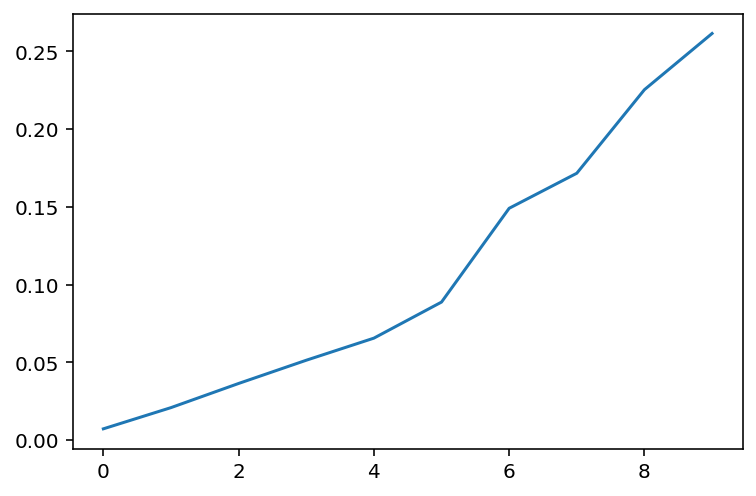

In [17]:
plt.plot(tiempo_medio_fit_svm)


La siguiente figura representa gráficamente los costes medios de entrenar la SVM en función del tamaño del conjunto de entrenamiento obtenidos en la celda anterior y lo compara con diversos polinomios. **Discuta cuál es el coste polinómico que mejor aproxima el coste de entrenar la SVM**.

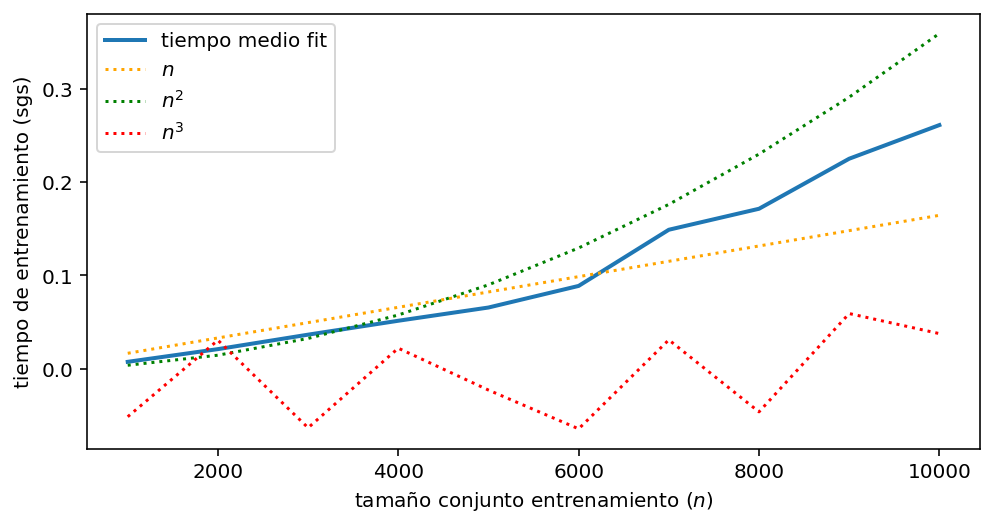

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(v_S, tiempo_medio_fit_svm, linewidth=2, label='tiempo medio fit')
plt.xlabel('tamaño conjunto entrenamiento ($n$)')
plt.ylabel('tiempo de entrenamiento (sgs)')
cc = np.mean(tiempo_medio_fit_svm / v_S)
cc3 = np.mean(tiempo_medio_fit_svm / v_S**3)
cc2 = np.mean(tiempo_medio_fit_svm / v_S**2)
plt.plot(v_S, v_S*cc, color='orange', linestyle=':', label='$n$')
plt.plot(v_S, v_S**2*cc2, color='green', linestyle=':', label='$n^2$')
plt.plot(v_S, v_S**3*cc3, color='red', linestyle=':',label='$n^3$')

plt.legend()


**Respuesta:**

**El coste polinomico de grado 2 es el que mas se ajusta al tiempo de vida medio**

Vamos a automatizar el cálculo del coste de entrenar una SVM a partir de los datos recabados en la celda anterior. Para ello vamos a crear un objeto [`PchipInterpolator`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.PchipInterpolator.html) que reciba peticiones en forma de tamaño de conjunto de entrenamiento y nos devuelva una estimación en segundos del coste de entrenar una SVM con él.

Tiempo para entrenar una SVM con 4534 muestras: 0.059 segundos


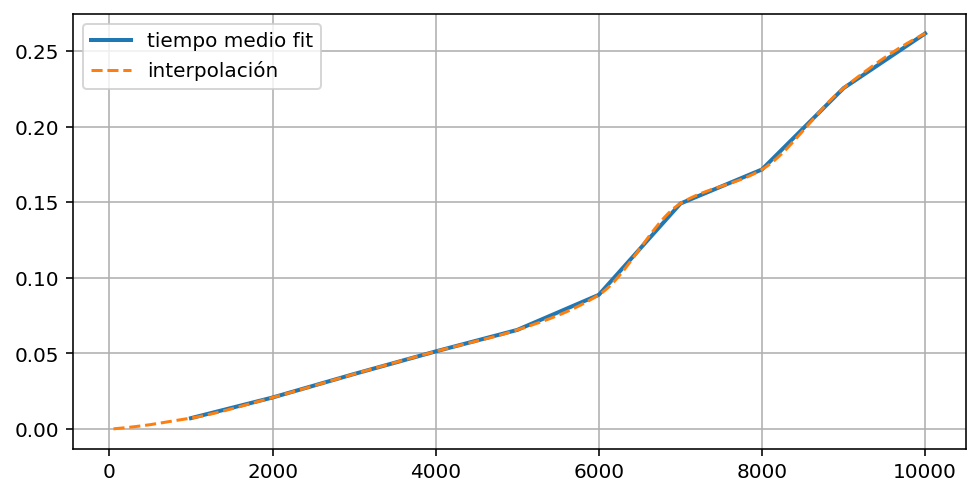

In [19]:
from scipy import interpolate
xs = np.hstack((np.zeros(1), v_S))
ys = np.hstack((np.zeros(1), tiempo_medio_fit_svm))
interpolar_tiempo_svm = interpolate.PchipInterpolator(xs, ys)
ss = 4534
tt = interpolar_tiempo_svm(ss)
print("Tiempo para entrenar una SVM con {0:d} muestras: {1:.3f} segundos".format(ss,tt))
plt.figure(figsize=(8,4))
xx = np.hstack((np.linspace(50,500,1000),np.linspace(1000,10000,1000)))
plt.plot(v_S, tiempo_medio_fit_svm, linewidth=2, label='tiempo medio fit')
plt.plot(xx, interpolar_tiempo_svm(xx), linestyle='--', label='interpolación')
plt.legend()
plt.grid()

## 2.3 Estimar el tiempo de hacer un clustering con Kmedias (10%)

Algunas de las estrategias para construir una SVM distribuida se apoyan en particionar el conjunto de entrenamiento con [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#). En esta sección vamos a analizar el coste de este algoritmo para distintos  números de clusters ($K$ de `KMeans`). Los distintos números de clusters con lo que vamos a trabajar vienen dados por el array `v_G` definido en la celda de abajo.

En la siguiente celda escriba código que implemente un bucle que recorra los distintos números de clusters de `v_G` y realice lo siguiente:

- llame a `cross_validate` con argumentos:
    - KMeans con el número de clusters dado por el elemento de `v_G` de esta iteración
    - El conjunto de entrenamiento original
    - `cv`=5
- calcule la media de `fit_time` y la almacene en el elemento correspondiente de `tiempo_medio_fit_Kmeans`

In [20]:
v_G = np.linspace(11,51,5,dtype=int)
tiempo_medio_fit_Kmeans = np.empty(len(v_G))
#############
# YOUR CODE #
#############
from sklearn.cluster import KMeans

for i,k in enumerate(v_G):
    print("Tamaño de muestra: " + str(t))
    print("Cantidad de clusters: " + str(k))
    cv_results = cross_validate(KMeans(n_clusters=k, random_state=0), Xtrain_s, Ytrain, cv=5,n_jobs=4)
    tiempo_medio_fit_Kmeans[i] = cv_results['fit_time'].mean()
#######
# END #
#######

Tamaño de muestra: 10000
Cantidad de clusters: 11
Tamaño de muestra: 10000
Cantidad de clusters: 21
Tamaño de muestra: 10000
Cantidad de clusters: 31
Tamaño de muestra: 10000
Cantidad de clusters: 41
Tamaño de muestra: 10000
Cantidad de clusters: 51


In [21]:
tiempo_medio_fit_Kmeans

array([1.41461005, 3.59234347, 5.71822228, 7.4001143 , 9.50493093])

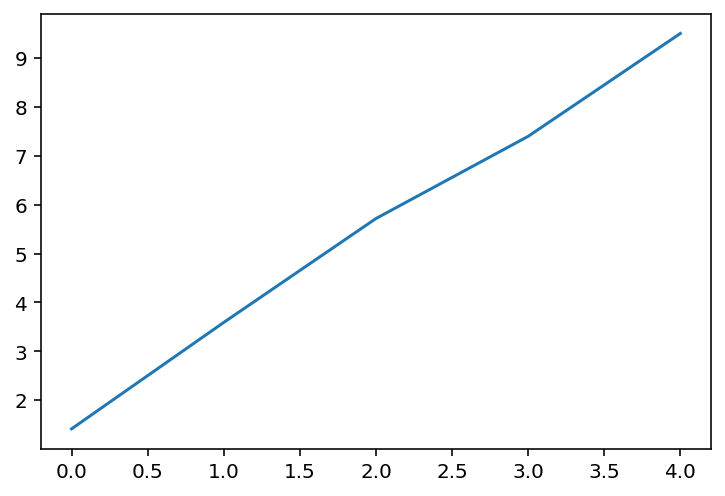

In [22]:
plt.plot(tiempo_medio_fit_Kmeans)

### Automatización del cálculo del coste de entrenar el KMeans

A partir de los valores almacenados en `tiempo_medio_fit_Kmeans` construya un objeto interpolador llamado `interpolar_tiempo_kmeans`  de la clase `PchipInterpolator` que interpole el tiempo necesario para entrenar un KMeans en función del número de clusters.


Tiempo para entrenar un Kmeans con 32 muestras: 5.901 segundos


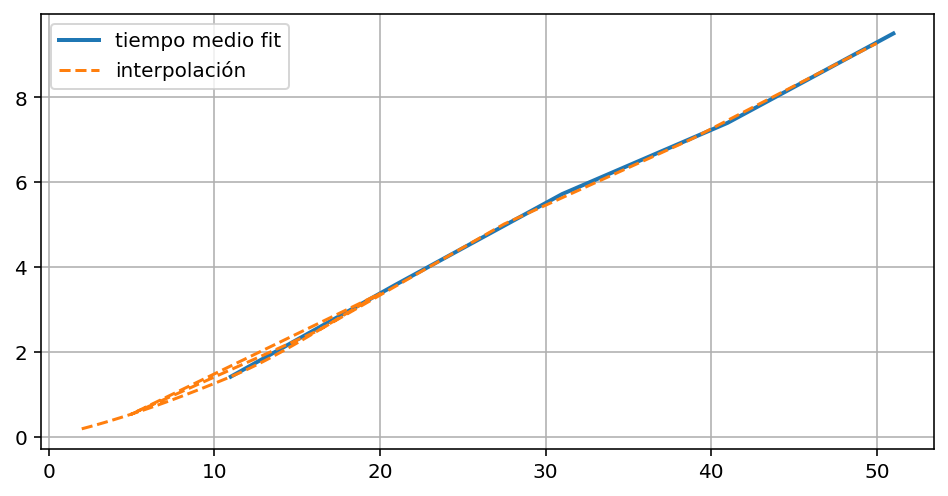

In [23]:
#############
# YOUR CODE #
#############
from scipy import interpolate
xs = np.hstack((np.zeros(1), v_G))
ys = np.hstack((np.zeros(1), tiempo_medio_fit_Kmeans))
interpolar_tiempo_kmeans = interpolate.PchipInterpolator(xs, ys)
ss = 32 # valores de cluster
tt = interpolar_tiempo_kmeans(ss)
print("Tiempo para entrenar un Kmeans con {0:d} muestras: {1:.3f} segundos".format(ss,tt))
plt.figure(figsize=(8,4))
xx = np.hstack((np.linspace(2,20,40),np.linspace(5,50,5))) # ajustar escala
plt.plot(v_G, tiempo_medio_fit_Kmeans, linewidth=2, label='tiempo medio fit')
plt.plot(xx, interpolar_tiempo_kmeans(xx), linestyle='--', label='interpolación')
plt.legend()
plt.grid()
#######
# END #
#######    

Representación gráfica de la interpolación y de los valores obtenidos

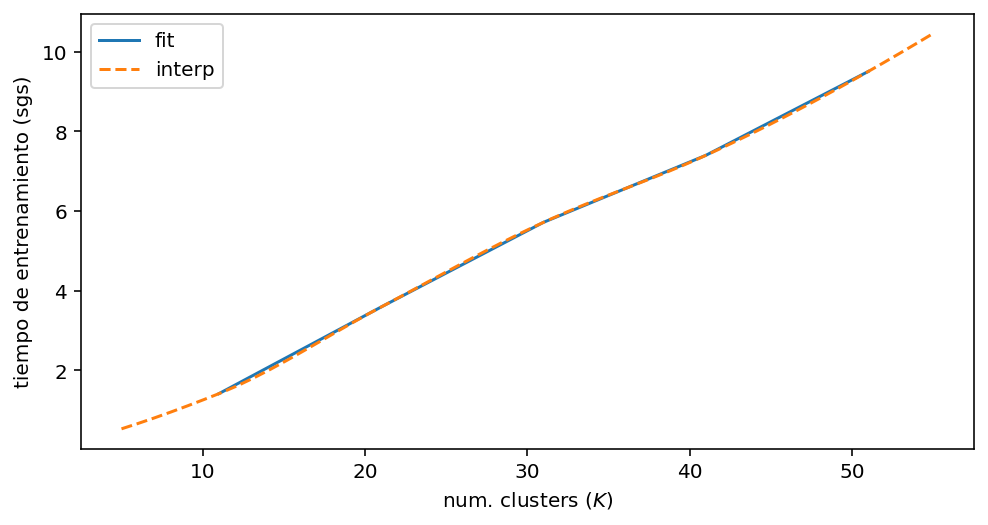

In [24]:
plt.figure(figsize=(8,4))
plt.xlabel('num. clusters ($K$)')
plt.ylabel('tiempo de entrenamiento (sgs)')
plt.plot(v_G, tiempo_medio_fit_Kmeans, label='fit')
xx = np.linspace(5,55,50)
plt.plot(xx, interpolar_tiempo_kmeans(xx), linestyle='--', label='interp')
plt.legend()

# 3. Estrategias para resolver un problema con SVM cuando el conjunto de entrenamiento es grande

## 3.1 Primera estrategia: Bagging SVMs (10%)

La primera estrategia es entrenar un *ensemble* donde el rol del *weak learner* lo desempeñan SVMs. Dado que la SVM es un clasificador razonablemente sofisticado estos *ensembles* no necesitan ser muy numerosos. **Vamos a probar tamaños de conjunto tales que las SVM más pesadas se entrenarían como mucho con unas 5000 observaciones**.

De hecho, los elementos del array `v_G` van a determinar los tamaños de *ensemble* que vamos a probar (`v_G=xx` significa un ensemble con $xx$ SVMs).

La clase `BaggingClassifier` de sklearn nos permite crear *ensembles* genéricos y es en la que vamos a basar el estudio de esta sección.

En la siguiente celda escriba código que implemente un bucle que recorra los elementos de `v_G` realizando las siguientes funcionalidades:
- determinar el número máximo de observaciones para entrenar cada *weak-learner* del *ensemble* `max_samples`. El valor de `max_samples` para cada tamaño de *ensemble* debe ser tal que el producto de `max_samples` por el tamaño del *ensemble* sea el tamaño del conjunto de entrenamiento original {`Xtrain_s, Ytrain`}. Almacene este valor en la posición correspondiente de `v_max_samples`.

- Entrenar un *bagging* de SVMs con los hiperparámetros óptimos de la SVM encontrados en la sección 2.1 y los argumentos `max_samples`y `n_estimators` correspondientes.

- Almacenar este *bagging* en el diccionario `dict_bagging` con la clave `n_estimators` correspondiente a la iteración

- Almacenar el acierto del bagging entrenado en esta iteración en el conjunto de test en la posición de `acierto_bagging` correspondiente

- Usar el interpolador del coste de entrenar una SVM para calcular el coste de entrenar el *ensemble* de cada iteración y almacenarlo en la posición correspondiente de `coste_bagging` 


In [29]:
acierto_bagging = np.empty(len(v_G))
coste_bagging = np.empty(len(v_G))
v_max_samples = np.empty(len(v_G))
dict_bagging = {}
#############
# YOUR CODE #
#############
for i,k in v_G : 
    v_max_samples[i] = Xtrain_s.shape[0] / k

    gamma = 0.0476
    C=10
    model = svm.SVC(C=C,kernel='rbf', gamma=gamma)
    model.fit(Xtrain_s,Ytrain)
    #######
# END #
#######

0 11
1 21
2 31
3 41
4 51


Representación gráfica de acierto y coste de entrenar el bagging de SVMs.

In [ ]:
ff,aa = plt.subplots(2,1,figsize=(6,6),sharex=True)
aa[0].plot(v_max_samples[::-1], acierto_bagging[::-1])
aa[0].set_xlabel('Tamaño conjunto entrenamiento')
aa[0].set_ylabel('Acierto en test')

aa[1].plot(v_max_samples[::-1], coste_bagging[::-1])
_=aa[1].set_ylabel('Coste del entrenamiento (sgs)')


## 3.2 Segunda estrategia: Usar KMeans para dividir el conjunto de entrenamiento en conjuntos disjuntos (10%)

Una alternativa al bagging va a ser construir una **SVM distribuida**. Para ello vamos a partir el conjunto de entrenamiento en trozos disjuntos y a entrenar una SVM con cada uno de esos trozos. En el siguiente capítulo del notebook usaremos estas SVMs para construir una SVM distribuida, pero en esta sección vamos a emplearlas como un comité de expertos donde la decisión final sobre la clase de cada muestra de test sea la clase mayoritaria propuesta por cada SVM (es decir, como si se hubiesen construido usando bagging, pero garantizando que cada observación del conjunto de entrenamiento sólo participa en una SVM del *ensemble*).

En la siguiente celda escriba código que implemente un bucle que recorra `v_G`. En cada iteración el elemento correspondiente de `v_G` marca el número de grupos en que se divide el conjunto de entrenamiento mediante `KMeans`. Cada iteración del bucle debe contener la siguiente funcionalidad:
- Supongamos que en esta iteración el elemento de `v_G` es $gg$, es decir, hay que partir el conjunto de entrenamiento en $gg$ particiones.
- Dividir conjunto de entrenamiento en grupos con KMeans y $gg$ centroides (el KMeans se aplica solo en las observaciones)
- Añadir el coste de este KMeans (estimado con el interpolador correspondiente) a la posición correspondiente de `coste_KMeans1_voto`
- Crear una lista llamada `lista_svc` para almacenar las $gg$ SVMs que se entrenen con cada uno de los subconjuntos de entrenamiento que resultan de partir en conjunto de entrenamiento en este número de grupos.
- Crear un array llamado `individual_pred_y_test` donde se almacenarán las predicciones hechas por cada SVM individual para el conjunto de test. Este array tendrá una fila por cada observación del conjunto de test y $gg$ columnas, una por cada una de las SVM que se hayan entrenado para esta iteración.
- Implementar un bucle interno que recorre cada una de las $gg$ particiones del clustering:
    - Supongamos estamos en la iteración $jj$ de las $gg$ iteraciones de este bucle interno
    - Entrenar una SVM con cada la partición $jj$, añadiendo el coste de este entrenaminento (estimado con el interpolador correspondiente) a la posición correspondiente de `coste_KMeans1_voto`)
    - Almacene esta SVM en `lista_svc`
    - Obtenga predicciones para el conjunto de test con esta SVM y almacene estas predicciones en la columna $jj$ de `individual_pred_y_test`
- Una vez que se hayan entrenado las $gg$ SVMs esta iteración del bucle principal, obtenga la predicción del *ensemble* sacando para cada fila de `individual_pred_y_test`  la clase mayoritaria
- Almacene en la posición correspondiente de  `acierto_KMeans1_voto` el acierto del *ensemble* para el conjunto de test
- Almacene `lista_svc` en la posición correspondiente de `dict_KMeans1` usando como clave el elemento de `v_G` correspondiente a esta iteración



In [ ]:
acierto_KMeans1_voto = np.empty(len(v_G))
coste_KMeans1_voto = np.zeros(len(v_G))
dict_KMeans1 = {}

#############
# YOUR CODE #
#############

#######
# END #
#######

Representación gráfica de acierto y coste comparando con el resultado del  bagging anterior.

In [ ]:
ff,aa = plt.subplots(2,1,figsize=(6,6),sharex=True)
aa[0].plot(v_max_samples[::-1], acierto_bagging[::-1], label='bagging')
aa[0].plot(v_max_samples[::-1], acierto_KMeans1_voto[::-1], label='KMeans + voto')
aa[0].set_xlabel('Tamaño conjunto entrenamiento')
aa[0].set_ylabel('Acierto en test')
aa[0].legend()
aa[1].plot(v_max_samples[::-1], coste_bagging[::-1], label='bagging')
aa[1].plot(v_max_samples[::-1], coste_KMeans1_voto[::-1], label='KMeans + voto')

_=aa[1].set_ylabel('Coste del entrenamiento (sgs)')
_=aa[1].legend()

# 4. Aproximar la SVM global con los vectores soporte de cada SVM local
Existe una alternativa a obtener las predicciones finales como la clase mayoriataria predicha por todos las SVM que forman el *ensemble*. Esta alternativa se basa en explotar la dispersión de la solución de la SVM y la propiedad de que los vectores soporte contienen toda la información necesaria para resolver el problema. Los vectores soporte de cada SVM del *ensemble* son muestras críticas para la definición de la frontera de clasificación. Por ello vamos a emplearlas para construir una **SVM global** usando los **vectores soporte identificados por cada SVM del ensemble**.

## 4.1 SVM global con los vectores soporte que salen del bagging (7.5%)

En el atributo `bagged_svm.estimators_` hay una lista con las SVM que forman el *ensemble*. Escriba código que implemente un bucle que recorra los valores de `v_G`. En cada iteración $gg$ de este bucle implemente un bucle interno que recorra los $gg$ elementos del *ensemble* y extraiga sus vectores soporte. Vaya almacenando estos vectores soporte en un mismo array, que servirá de conjunto de entrenamiento para la SVM global.

**Nota**. Dentro de un objeto `SVC` hay dos atributos que son de interés para resolver este apartado:
- `support_vectors_` tiene los vectores soporte
- `dual_coef_` tiene los multiplicadores de Lagrange ($\alpha_i$) correspondientes a los vectores soporte **multiplicados** por la etiqueta del vector soporte ($y_i$), luego puede usarse para recuperar el target original del vector soporte.

Una vez que tenga el conjunto de entrenamiento formado por los vectores soporte, entrene una SVM con él empleando los hiperparámetros óptimos encontrados al principio del notebook. 

Evalúe el conjunto de test con esta SVM global y almacene el resultado en la posición correspondiente de `acierto_bagging_SVM`

In [ ]:
acierto_bagging_SVM = np.empty(len(v_G))
coste_bagging_SVM = coste_bagging.copy()
#############
# YOUR CODE #
#############

#######
# END #
#######

In [ ]:
ff,aa = plt.subplots(2,1,figsize=(6,6),sharex=True)
aa[0].plot(v_max_samples[::-1], acierto_bagging[::-1], label='bagging')
aa[0].plot(v_max_samples[::-1], acierto_KMeans1_voto[::-1], label='KMeans + voto')
aa[0].plot(v_max_samples[::-1], acierto_bagging_SVM[::-1], label='bagging + SVM global')

aa[0].set_xlabel('Tamaño conjunto entrenamiento')
aa[0].set_ylabel('Acierto en test')
aa[0].legend()
aa[1].plot(v_max_samples[::-1], coste_bagging[::-1], label='bagging')
aa[1].plot(v_max_samples[::-1], coste_KMeans1_voto[::-1], label='KMeans + voto')
aa[1].plot(v_max_samples[::-1], coste_bagging_SVM[::-1], label='bagging + SVM global')

_=aa[1].set_ylabel('Coste del entrenamiento (sgs)')
aa[1].legend()

## 4.2 SVM global con los vectores soporte que salen de las SVM de la estrategia 3.2 (7.5%)

Adapte el procedimiento de la sección 4.1 para rescatar los vectores soporte de las mini-SVM de la estrategia de la sección 3.2 y entrenar y evaluar una SVM global con estos vectores soporte. Emplee los arrays `acierto_KMeans1_SVM` y `coste_KMeans1_SVM` para almacenar el acierto de estas SVMs globales y el coste de entrenarlas, respectivamente.

In [ ]:
acierto_KMeans1_SVM = np.empty(len(v_G))
coste_KMeans1_SVM = coste_KMeans1_voto.copy()
#############
# YOUR CODE #
#############

#######
# END #
#######

In [ ]:
ff,aa = plt.subplots(2,1,figsize=(6,6),sharex=True)
aa[0].plot(v_max_samples[::-1], acierto_bagging[::-1], label='bagging')
aa[0].plot(v_max_samples[::-1], acierto_KMeans1_voto[::-1], label='KMeans + voto')
aa[0].plot(v_max_samples[::-1], acierto_bagging_SVM[::-1], label='bagging + SVM global')
aa[0].plot(v_max_samples[::-1], acierto_KMeans1_SVM[::-1], label='KMeans + SVM global')

aa[0].set_xlabel('Tamaño conjunto entrenamiento')
aa[0].set_ylabel('Acierto en test')
aa[0].legend()
aa[1].plot(v_max_samples[::-1], coste_bagging[::-1], label='bagging')
aa[1].plot(v_max_samples[::-1], coste_KMeans1_voto[::-1], label='KMeans + voto')
aa[1].plot(v_max_samples[::-1], coste_bagging_SVM[::-1], label='bagging + SVM global')
aa[1].plot(v_max_samples[::-1], coste_KMeans1_SVM[::-1], label='KMeans + SVM global')

_=aa[1].set_ylabel('Coste del entrenamiento (sgs)')
aa[1].legend()

# 5. Discusión de los resultados (5%)

La siguiente gráfica representa los aciertos y los costes de entrenar el clasificador global con cada estrategia. A la vista de estos resultados discuta las ventajas e inconvenientes de cada estrategia.

In [ ]:
ff,aa = plt.subplots(2,1,figsize=(6,6),sharex=True)
aa[0].plot(v_max_samples[::-1], acierto_bagging[::-1], label='bagging')
aa[0].plot(v_max_samples[::-1], acierto_KMeans1_voto[::-1], label='KMeans + voto')
aa[0].plot(v_max_samples[::-1], acierto_bagging_SVM[::-1], label='bagging + SVM global')
aa[0].plot(v_max_samples[::-1], acierto_KMeans1_SVM[::-1], label='KMeans + SVM global')

aa[0].set_xlabel('Tamaño conjunto entrenamiento')
aa[0].set_ylabel('Acierto en test')
aa[0].legend()
aa[1].plot(v_max_samples[::-1], coste_bagging[::-1], label='bagging')
aa[1].plot(v_max_samples[::-1], coste_KMeans1_voto[::-1], label='KMeans + voto')
aa[1].plot(v_max_samples[::-1], coste_bagging_SVM[::-1], label='bagging + SVM global')
aa[1].plot(v_max_samples[::-1], coste_KMeans1_SVM[::-1], label='KMeans + SVM global')

_=aa[1].set_ylabel('Coste del entrenamiento (sgs)')
aa[1].legend()

# 6. Analizar el comportamiento de las SVM individuales (10%)


El notebook se ha centrado en construir una solución global empleando todas las observaciones del conjunto de entrenamiento disponible. Sin embargo, podríamos analizar cómo de buenas son las SVM que se han construido para formar los *ensembles* (usando solo una parte de las observaciones de entrenamiento) para ver cuál sería el resultado de usar una sola de estas SVM en lugar del clasificador global (bien con votos o bien con la SVM global de la sección 4).

Escriba código que construya los siguientes arrays
- `acierto_individual_medio_bagging`: promedio de los aciertos de las SVM del bagging (para cada valor de `v_G`) en el conjunto de test.
- `acierto_individual_mejor_bagging`: mejor acierto individual de todas las SVM del bagging para cada valor de `v_G` en el conjunto de test.
- `acierto_individual_peor_bagging`: mejor acierto individual de todas las SVM del bagging para cada valor de `v_G` en el conjunto de test.
- `acierto_individual_medio_KMeans1`: promedio de los aciertos de las SVM de los *ensembles* de la sección 3.2 (para cada valor de `v_G`) en el conjunto de test.
- `acierto_individual_mejor_KMeans1`: mejor acierto individual de todas las SVM de los *ensembles* de la sección 3.2 para cada valor de `v_G` en el conjunto de test.
- `acierto_individual_peor_KMeans1`: mejor acierto individual de todas las SVM de los *ensembles* de la sección 3.2 para cada valor de `v_G` en el conjunto de test.

Analice estos arrays y discuta cuál es la mejor opción para construir un clasificador individual que tenga buenas prestaciones con alta probabilidad (es decir, sin construir muchos clasificadores individuales).

In [ ]:
acierto_individual_medio_bagging = np.empty(len(v_G))
acierto_individual_mejor_bagging = np.empty(len(v_G))
acierto_individual_peor_bagging = np.empty(len(v_G))
acierto_individual_medio_KMeans1 = np.empty(len(v_G))
acierto_individual_mejor_KMeans1 = np.empty(len(v_G))
acierto_individual_peor_KMeans1 = np.empty(len(v_G))

#############
# YOUR CODE #
#############

#######
# END #
#######